# Housing Price Predictor - Kaggle comp

Data is from kaggle competition https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. <br>
The goal is to train a model that best fit the data and shows what attributes are the major influencer for the price of house.

## Import

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.plotly as py

from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor

np.random.seed(42)
plotly.tools.set_credentials_file(username='KerwinYi', api_key='KE5S1cE761tj5fJCoFKT')
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

## Functions

In [2]:
from typing import TextIO, Dict, Tuple

def owari(file: TextIO) -> Dict[str, list]:
    result = {}
    key = None
    line = file.readline()
    while line != '':
        # Break down to curr line and new line.
        curr, line = break_line(line)
        if curr == '':
            continue

        # Search the head line. Note: double quote is cleaned in break_line.
        if curr[0].isalnum():
            key, info = break_header(curr)
            result[key] = [info, {}]
        else:
            curr = curr.lstrip()
            if curr != '':
                k, v = gather_info(curr)
                result[key][1][k] = v

        # Read new line.
        if line == '':
            line = file.readline()
    return result


def gather_info(curr: str) -> Tuple[str, str]:
    """ Get each key, value pair for non_header line.
    >>> print(gather_info('20\\t1-STORY 1946 & NEWER ALL STYLES'))
    ('20', '1-STORY 1946 & NEWER ALL STYLES')
    """
    i = 0
    while curr[i] not in '\t ':
        i += 1
    return curr[:i], curr[i:].strip()


def break_header(curr: str) -> Tuple[str, str]:
    """ Break the header to Dict key and Attribute information.
    >>> print(break_header('MSSubClass: Identifies the sale.'))
    ('MSSubClass', 'Identifies the sale.')
    """
    index = curr.find(':')
    return curr[:index].rstrip(), curr[index+1:].strip()


def clean(line: str) -> str:
    """ Remove the double quotation mark."""
    if len(line) != 0 and line[0] == '"':
        return line[1:]
    return line


def break_line(line: str) -> Tuple[str, str]:
    """ Break each line to parts, considering \t and \n.
    Return 1st entry: str before first occurrence of \n.
    Return 2nd entry: remain str except \n.
    """
    i = 0
    result = ''
    while i < len(line) - 1:
        if line[i] == '\\':
            if line[i+1] == 't':
                result += '\t'
                i += 1
            elif line[i+1] == 'n':
                return clean(result), line[i+2:]
            else:
                result += '\\'
        else:
            result += line[i]
        i += 1
    return clean(result + line[-1]), ''

In [3]:
def data_describ(data, attrib):
    print(attrib, ': ', data[attrib][0])
    for i in data[attrib][1]:
        print('\t', i, ': ', data[attrib][1][i])

In [4]:
def replace_cat(data, attrib, dic):
    """Return a series where the categories in the original dataset is replaced with the new ones."""
    pairs = dic[attrib][1]
    new = []
    for i in data[attrib]:
        new.append(pairs.get(str(i), np.nan))
    return pd.Series(new)

In [5]:
def cat_to_int(data, attrib, categories, start_from=0):
    """Convert data[attrib] from categorical to numerical according to the order given by categories."""
    dic = {i: count for count, i in enumerate(categories, start_from)}
    new = []
    for i in data[attrib]:
        new.append(dic.get(i, np.nan))
    return pd.Series(new)

In [6]:
def attrib_separator(X, incomplete_threshold=0.2):
    """Separate the attributes into three categories: attrib that has too many NAs; num attrib; cat attrib."""
    incomplete_attribs, num_attribs, cat_attribs = [], [], []
    for attrib in X.columns:
        if X[attrib].isna().sum() / X.shape[0] > incomplete_threshold:
            incomplete_attribs.append(attrib)
        elif X[attrib].dtype == 'O': # This means object (str).
            cat_attribs.append(attrib)
        else:
            num_attribs.append(attrib)
    return incomplete_attribs, num_attribs, cat_attribs

## Fetch data

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
train.shape

(1460, 81)

In [9]:
test.shape

(1459, 80)

Note that the test here is not the test set. We will predict the house price for this 'test' set and then upload to kaggle to see what the final score is.

In [10]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [11]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

There are several attributes that have too many NAs, let's first get the description for all the data. We will create a dictionary where the key is attribute name and the value is description for the value, just for convenience.

In [13]:
description_file = open('data_description.txt')
data_dict = owari(description_file)
description_file.close()

Let's check what if the dictionary works as we wanted.

In [14]:
data_describ(data_dict, 'MSSubClass')

MSSubClass :  Identifies the type of dwelling involved in the sale.
	 20 :  1-STORY 1946 & NEWER ALL STYLES
	 30 :  1-STORY 1945 & OLDER
	 40 :  1-STORY W/FINISHED ATTIC ALL AGES
	 45 :  1-1/2 STORY - UNFINISHED ALL AGES
	 50 :  1-1/2 STORY FINISHED ALL AGES
	 60 :  2-STORY 1946 & NEWER
	 70 :  2-STORY 1945 & OLDER
	 75 :  2-1/2 STORY ALL AGES
	 80 :  SPLIT OR MULTI-LEVEL
	 85 :  SPLIT FOYER
	 90 :  DUPLEX - ALL STYLES AND AGES
	 120 :  1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 :  1-1/2 STORY PUD - ALL AGES
	 160 :  2-STORY PUD - 1946 & NEWER
	 180 :  PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 :  2 FAMILY CONVERSION - ALL STYLES AND AGES


In [15]:
len(data_dict.keys())

79

Note that there are only 79 attributes here. Let's check which ones are not here.

In [16]:
set(train.columns) - set(data_dict.keys())

{'BedroomAbvGr', 'Id', 'KitchenAbvGr', 'SalePrice'}

In [17]:
set(data_dict.keys()) - set(train.columns)

{'Bedroom', 'Kitchen'}

Looks like in description 'BedroomAbvGr' and 'KitchenAbvGr' are simply refered to as 'Bedroom' and 'Kitchen'. Let's check if this is the case.

In [18]:
data_describ(data_dict, 'Bedroom')
data_describ(data_dict, 'Kitchen')

Bedroom :  Bedrooms above grade (does NOT include basement bedrooms)
Kitchen :  Kitchens above grade


Ok, we now know that 'BedroomAbvGr' is just 'Bedroom Above Ground'. So those two actually match, let's update that in our dictionary.

In [19]:
data_dict['BedroomAbvGr'] = data_dict['Bedroom']
data_dict['KitchenAbvGr'] = data_dict['Kitchen']
del data_dict['Bedroom']
del data_dict['Kitchen']

print('Bedroom' in data_dict.keys())
print('Kitchen' in data_dict.keys())

False
False


Alright, now we have corrected those two, but note that 'Id' and 'SalePrice' are still not included in the description. This is not a problem since 'Id' is just the id of the house and 'SalePrice' is just the label (i.e. the price of the house). Let's check if this is right.

In [20]:
train['Id'][:10]

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: Id, dtype: int64

In [21]:
train['SalePrice'][:10]

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

Perfect! Now we can move on to analyze what other attributes are!

## Data Analysis

The first attribute we can safely put aside would be 'Id' since it is very unlikely that 'Id' would have any affect on the house price. Unless of course someone intentionally make the dataset such that high value house goes first. In that case, we still need to remove the 'Id' attribute since it SHOULD NOT affect the housing price according to common knowledge.

Now let's go over the attributes according to the order they appear in the dataset.

In [22]:
all_attrib = list(train.columns)

In [23]:
all_attrib.remove('Id')
all_attrib.remove('SalePrice')

In [24]:
X_train = pd.DataFrame(train['SalePrice'].copy())
y_train = train['SalePrice'].copy()
X_test = pd.DataFrame()

### MSSubClass

In [25]:
all_attrib[0]

'MSSubClass'

In [26]:
data_describ(data_dict, 'MSSubClass')

MSSubClass :  Identifies the type of dwelling involved in the sale.
	 20 :  1-STORY 1946 & NEWER ALL STYLES
	 30 :  1-STORY 1945 & OLDER
	 40 :  1-STORY W/FINISHED ATTIC ALL AGES
	 45 :  1-1/2 STORY - UNFINISHED ALL AGES
	 50 :  1-1/2 STORY FINISHED ALL AGES
	 60 :  2-STORY 1946 & NEWER
	 70 :  2-STORY 1945 & OLDER
	 75 :  2-1/2 STORY ALL AGES
	 80 :  SPLIT OR MULTI-LEVEL
	 85 :  SPLIT FOYER
	 90 :  DUPLEX - ALL STYLES AND AGES
	 120 :  1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 :  1-1/2 STORY PUD - ALL AGES
	 160 :  2-STORY PUD - 1946 & NEWER
	 180 :  PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 :  2 FAMILY CONVERSION - ALL STYLES AND AGES


In [27]:
train['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

MSSubclass represents the type of dewllings, so it should be a categorical data, let's make it more clear.

In [28]:
X_train['MSSubClass'] = replace_cat(train, 'MSSubClass', data_dict)
X_test['MSSubClass'] = replace_cat(test, 'MSSubClass', data_dict)

Let's first check if the observations in train cover all the categories.

In [29]:
set(data_dict['MSSubClass'][1].values()) - set([str(i) for i in dict(X_train['MSSubClass'].value_counts()).keys()])

{'1-1/2 STORY PUD - ALL AGES'}

In [30]:
sum(X_test['MSSubClass'] == '1-1/2 STORY PUD - ALL AGES')

1

Looks like there is no '1-1/2 STORY PUD - ALL AGES' in training set, but there is one observation in test that has this.

In [31]:
X_train['MSSubClass'].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          536
2-STORY 1946 & NEWER                                     299
1-1/2 STORY FINISHED ALL AGES                            144
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     87
1-STORY 1945 & OLDER                                      69
2-STORY PUD - 1946 & NEWER                                63
2-STORY 1945 & OLDER                                      60
SPLIT OR MULTI-LEVEL                                      58
DUPLEX - ALL STYLES AND AGES                              52
2 FAMILY CONVERSION - ALL STYLES AND AGES                 30
SPLIT FOYER                                               20
2-1/2 STORY ALL AGES                                      16
1-1/2 STORY - UNFINISHED ALL AGES                         12
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   10
1-STORY W/FINISHED ATTIC ALL AGES                          4
Name: MSSubClass, dtype: int64

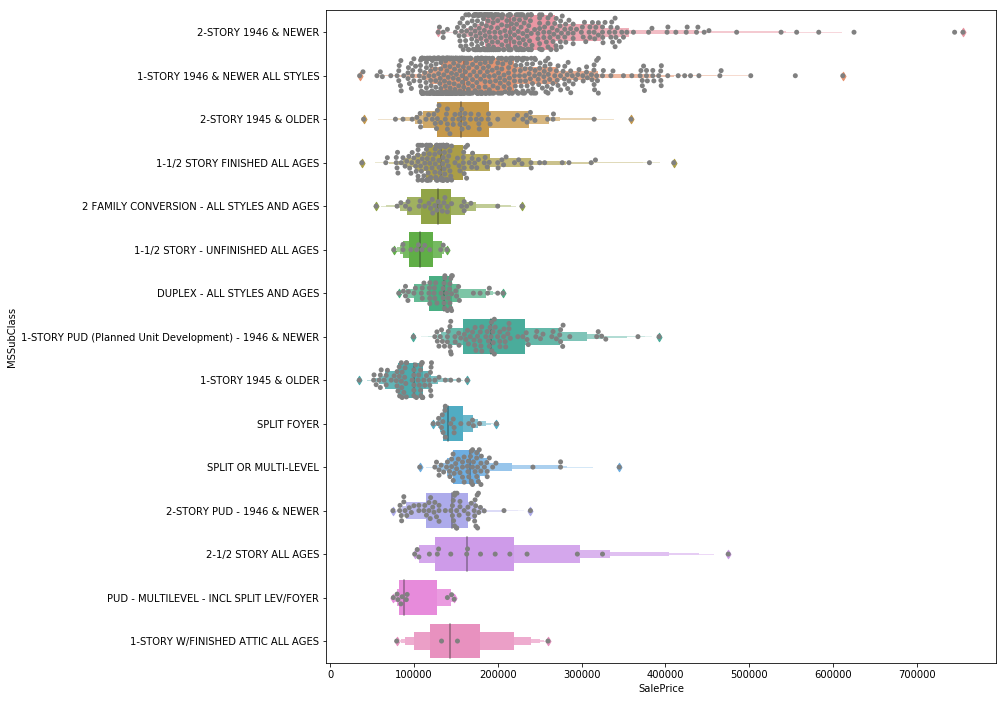

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.boxenplot(y='MSSubClass', x='SalePrice', data=X_train, orient='h')
ax = sns.swarmplot(y='MSSubClass', x='SalePrice', data=X_train, orient='h', color='.5')
plt.show()

* Some of the types have very limited number of observations, such as '1-STORY W/FINISHED ATTIC ALL AGES'.
* 'PUD-MULTILEVEL-INCL SPLIT LEV/FOYER' is quite polarized, while most are relatively dense.

We can further group them according to:
* number of stories
* new or old

The guess is that number of stories should have a positive influence on price; and newer houses would be more expensive than old ones.

#### Number of stories

In [33]:
by_story = []
for i in X_train['MSSubClass']:
    if '1-STORY' in i:
        by_story.append(1)
    elif '2-STORY' in i:
        by_story.append(2)
    elif '1-1/2 STORY' in i:
        by_story.append(1.5)
    elif '2-1/2 STORY' in i:
        by_story.append(2.5)
    else:
        by_story.append(0)

mssubclass_story = pd.DataFrame(list(zip(by_story, train['SalePrice'])))
mssubclass_story.columns = ['MSSubClass_story', 'SalePrice']

In [34]:
mssubclass_story['MSSubClass_story'].value_counts()

1.0    696
2.0    422
0.0    170
1.5    156
2.5     16
Name: MSSubClass_story, dtype: int64

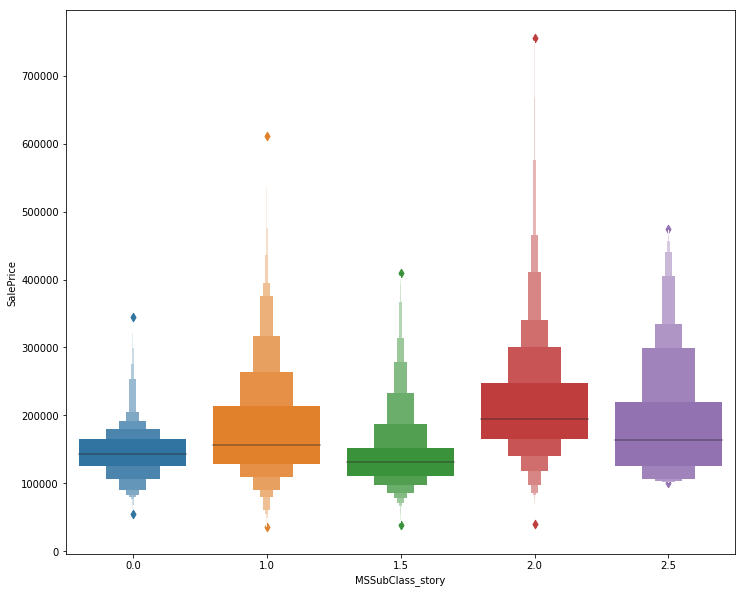

In [35]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='MSSubClass_story', y='SalePrice', data=mssubclass_story)
plt.show()

Indeed, 2 story is the most expensive ones with the median at a little below 200,000, while the median for 1 story is just at 150,000. Surprisingly, 1 story is generally more expensive than 1-1/2 story, and same for 2 and 2-1/2.

#### Old/New/All ages

In [36]:
by_time = []
for i in X_train['MSSubClass']:
    if '1945 & OLDER' in i:
        by_time.append('old')
    elif '1946 & NEWER' in i:
        by_time.append('new')
    elif 'ALL AGES' in i:
        by_time.append('all ages')
    else:
        by_time.append('other')

mssubclass_time = pd.DataFrame(list(zip(by_time, train['SalePrice'])))
mssubclass_time.columns = ['MSSubClass_time', 'SalePrice']

In [37]:
mssubclass_time['MSSubClass_time'].value_counts()

new         985
all ages    176
other       170
old         129
Name: MSSubClass_time, dtype: int64

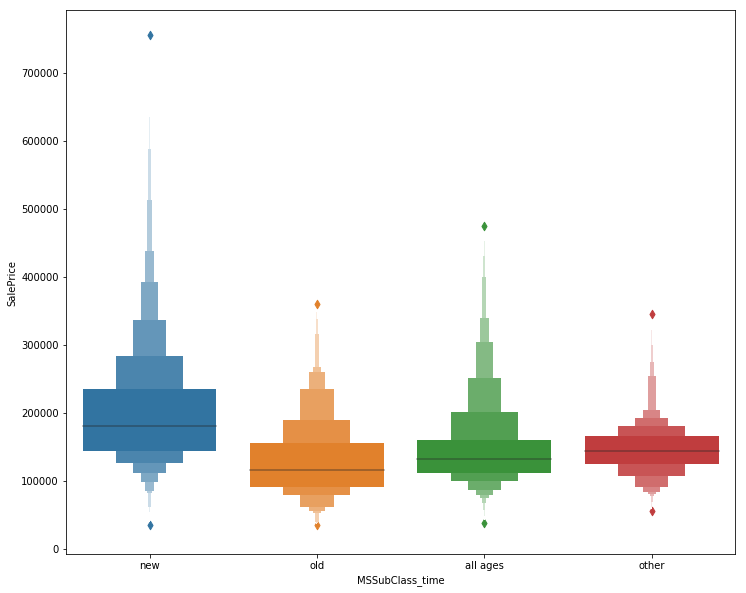

In [38]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='MSSubClass_time', y='SalePrice', data=mssubclass_time)
plt.show()

Same as our hypothesis, new houses are generally more expensive than old ones. All ages does not seem to have much difference with old, so it is an option to create a new attribute which simply indicates whether the houes is new or not.

**MSSubClass is an essential attribute, but for some of the categories there are too few observations so we have the option to combine them. We can also create new attributes 'mssubclass_num_story' and 'mssubclass_new' based on that.**

### MSZoning

In [39]:
all_attrib[1]

'MSZoning'

In [40]:
data_describ(data_dict, 'MSZoning')

MSZoning :  Identifies the general zoning classification of the sale.
	 A :  Agriculture
	 C :  Commercial
	 FV :  Floating Village Residential
	 I :  Industrial
	 RH :  Residential High Density
	 RL :  Residential Low Density
	 RP :  Residential Low Density Park
	 RM :  Residential Medium Density


In [41]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

So training set only has 5 categories. 'C (all)' here should be just 'C', but it does not matter too much so we will not modify that.

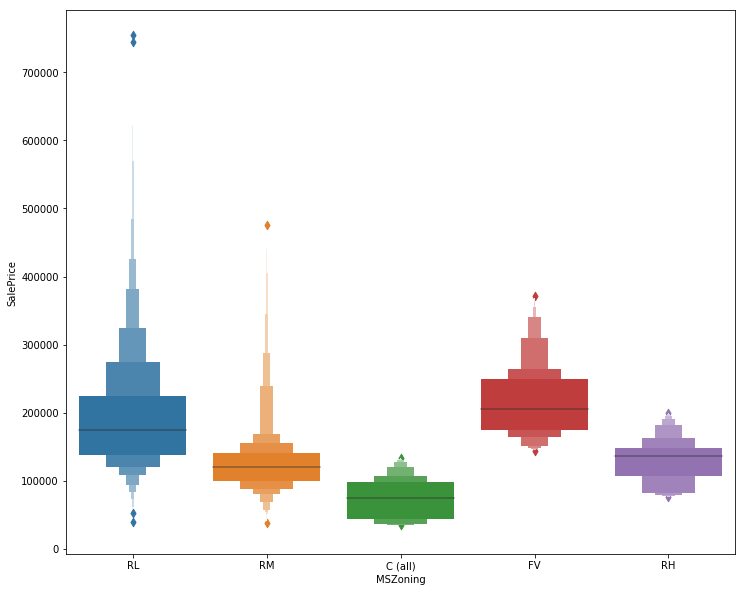

In [42]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='MSZoning', y='SalePrice', data=train)
plt.show()

**MSZoning itself is already a pretty good attribute, with different categories showing quite different median and distribution. 'FV' here is the most expensive one, while 'C (all)' is the only one whose median is below 100,000.**

In [43]:
X_train['MSZoning'] = train['MSZoning'].copy()
X_test['MSZoning'] = test['MSZoning'].copy()

### LotFrontage

In [44]:
all_attrib[2]

'LotFrontage'

In [45]:
data_describ(data_dict, 'LotFrontage')

LotFrontage :  Linear feet of street connected to property


We are having our first numerical type.

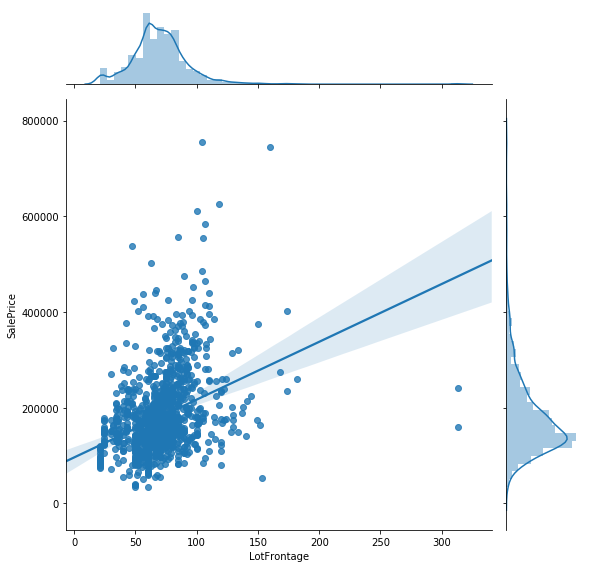

In [46]:
sns.jointplot(kind='reg', x='LotFrontage', y='SalePrice', data=train, height=8)
plt.show()

It is generally the trend that the longer the frontage, the higher the price. But there are two outliers whose LotFrontage is more than 300 but price is quite low. Maybe this is related to the the location? Let's check.

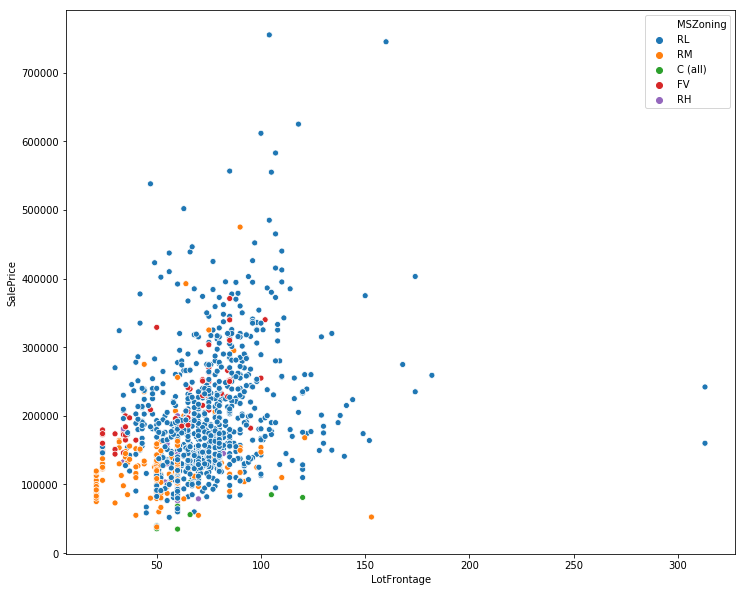

In [47]:
plt.subplots(figsize=(12,10))
sns.scatterplot(x='LotFrontage', y='SalePrice', hue='MSZoning', data=train)
plt.show()

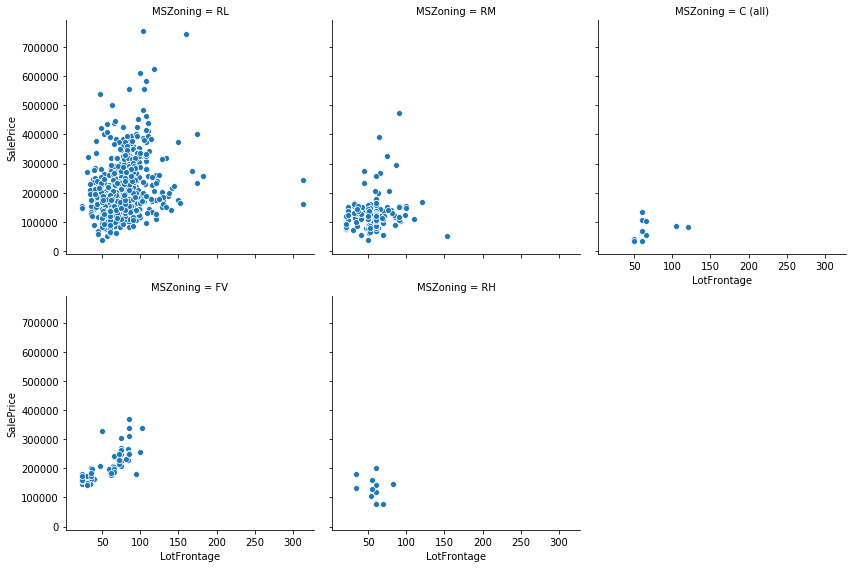

In [48]:
g = sns.FacetGrid(train, col='MSZoning', col_wrap=3, height=4)
g.map(sns.scatterplot, 'LotFrontage', 'SalePrice')
plt.show()

We can see that 'RM', 'C' and 'RH' are generally cheaper with smaller LotFrontage. 'FV', on the other hand, does have low LotFrontage, but the price is generally higher compared to 'RM', 'C' and 'RH'. 'RL' has the most observations, with the majority at around 30 to 150 LotFrontage and 0 to 500,000 for price, it also has several outliers.

**LotFrontage is generally positively correlated with SalePrice, but also affected by MSZoning. Location approximately determines the range of LotFrontage and corresponding SalePrice.**

In [49]:
X_train['LotFrontage'] = train['LotFrontage'].copy()
X_test['LotFrontage'] = test['LotFrontage'].copy()

### LotArea

In [50]:
all_attrib[3]

'LotArea'

In [51]:
data_describ(data_dict, 'LotArea')

LotArea :  Lot size in square feet


LotArea should be positively correlated with SalePrice, and it should be quite strong since the larger tha area the higher the price is generally true.

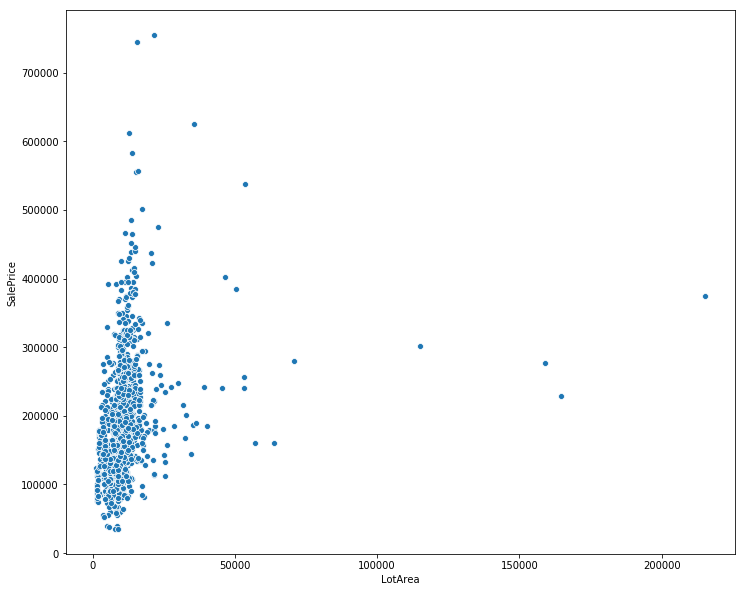

In [52]:
plt.subplots(figsize=(12,10))
sns.scatterplot(x='LotArea', y='SalePrice', data=train)
plt.show()

In [53]:
log_lotarea = train[['LotArea', 'SalePrice']]
log_lotarea['LotArea_log'] = np.log(log_lotarea['LotArea'])

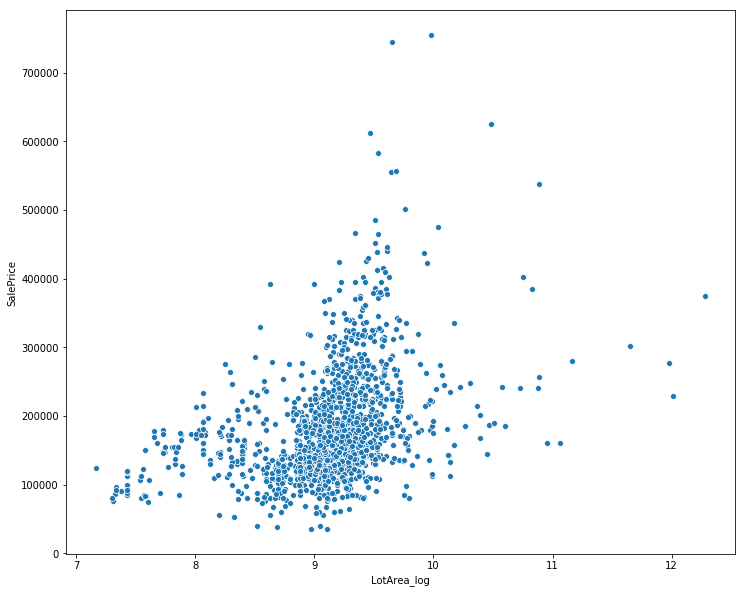

In [54]:
plt.subplots(figsize=(12,10))
sns.scatterplot(x='LotArea_log', y='SalePrice', data=log_lotarea)
plt.show()

**Indeed this is positively correlated as expected.**

In [55]:
X_train['LotArea'] = train['LotArea'].copy()
X_test['LotArea'] = test['LotArea'].copy()

### Street

In [56]:
all_attrib[4]

'Street'

In [57]:
data_describ(data_dict, 'Street')

Street :  Type of road access to property
	 Grvl :  Gravel
	 Pave :  Paved


In [58]:
train['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

Looks like we only have 6 road unpaved... Good for the society, but not so good for us since we lack the comparison between pave and unpaved. Let's check the price of Grvl.

In [59]:
grvl = train[train['Street'] == 'Grvl']
pave = train[train['Street'] == 'Pave']

In [60]:
print("Grvl mean: ", grvl['SalePrice'].mean())
print("Pave mean: ", pave['SalePrice'].mean())

print("Grvl std: ", grvl['SalePrice'].std())
print("Pave std: ", pave['SalePrice'].std())

Grvl mean:  130190.5
Pave mean:  181130.53851444292
Grvl std:  65446.25399134774
Pave std:  79446.59731743205


**Paved roads indeed lead to higher house price. The lack of information for unpaved ones means that when using imputer, all NAs will be categorized as paved.**

***We'll NOT include this attribute!***

### Alley

In [61]:
all_attrib[5]

'Alley'

In [62]:
data_describ(data_dict, 'Alley')

Alley :  Type of alley access to property
	 Grvl :  Gravel
	 Pave :  Paved
	 NA :  No alley access


In [63]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

**Now this is a more even distribution, but in a bad way. We have more than 1400 observations in total, and yet we only have 91 that has 'Alley' attributes.**

***We will NOT include this attribute for sure since this is not helpful at all!***

### LotShape

In [64]:
all_attrib[6]

'LotShape'

In [65]:
data_describ(data_dict, 'LotShape')

LotShape :  General shape of property
	 Reg :  Regular
	 IR1 :  Slightly irregular
	 IR2 :  Moderately Irregular
	 IR3 :  Irregular


In [66]:
train['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

This attribute is quite interesting. We do not know what 'regular' means here, but from the description for this attribute, it may be a good idea to convert into numerical data! Let's use integer to indicate 'LotShape', where the larger the number, the more irregular it is.

In [67]:
lotshape_int = cat_to_int(train, 'LotShape', ['Reg', 'IR1', 'IR2', 'IR3'])

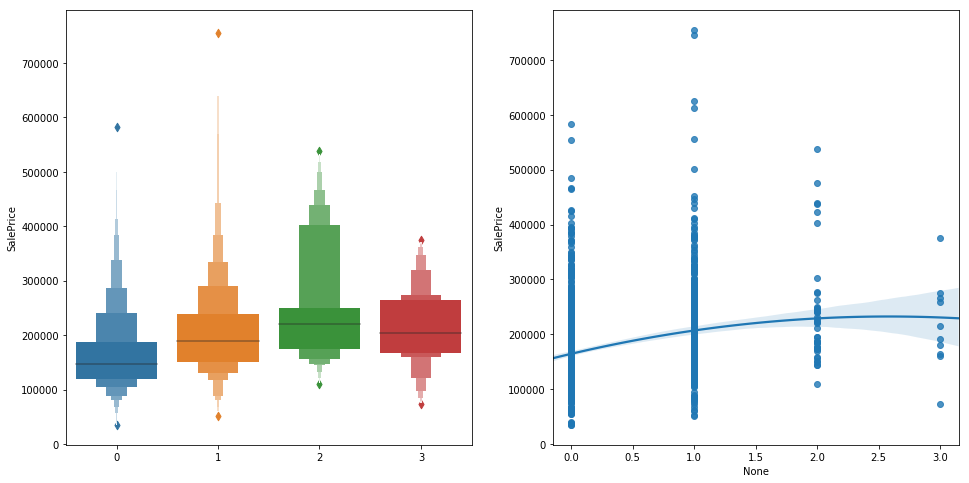

In [68]:
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1, 2, 1)
sns.boxenplot(x=lotshape_int, y=train['SalePrice'])

plt.subplot(1, 2, 2)
sns.regplot(x=lotshape_int, y=train['SalePrice'], order=2)

plt.show()

In [69]:
lotshape_table = []
for i in range(4):
    cat = X_train['SalePrice'][lotshape_int == i]
    lotshape_table.append([cat.shape[0], cat.mean(), cat.median(), cat.std()])
lotshape_table = pd.DataFrame(lotshape_table)
lotshape_table.columns = ['Number of observations', 'Mean', 'Median', 'Standard Deviation']
lotshape_table

,Number of observations,Mean,Median,Standard Deviation
0,925,164754.818378,146000.0,69673.427215
1,484,206101.665289,189000.0,85858.489559
2,41,239833.365854,221000.0,99669.427362
3,10,216036.500000,203570.0,82540.334855


**Most houses are regular or slightly irregular. Moderately irregular houses are generally more expensive but have a higher standard deviation. They seem to be more expensive probably because they are harder to build, or perhaps people prefer to live in a house that is different from others'. We will keep the numerical one instead of the categorical one because the level of irregularness seems to have effect on house price.**

In [70]:
X_train['LotShape_int'] = lotshape_int
X_test['LotShape_int'] = cat_to_int(test, 'LotShape', ['Reg', 'IR1', 'IR2', 'IR3'])

### LandContour

In [71]:
all_attrib[7]

'LandContour'

In [72]:
data_describ(data_dict, 'LandContour')

LandContour :  Flatness of the property
	 Lvl :  Near Flat/Level
	 Bnk :  Banked - Quick and significant rise from street grade to building
	 HLS :  Hillside - Significant slope from side to side
	 Low :  Depression


I searched online to see what a 'depression land contour' is, and here is the result:<br>
*A closed contour, inside of which the ground or geologic structure is at a lower elevation than that outside, and distinguished on a map from other contour lines by hachures marked on the downslope or downdip side.*

In [73]:
train['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

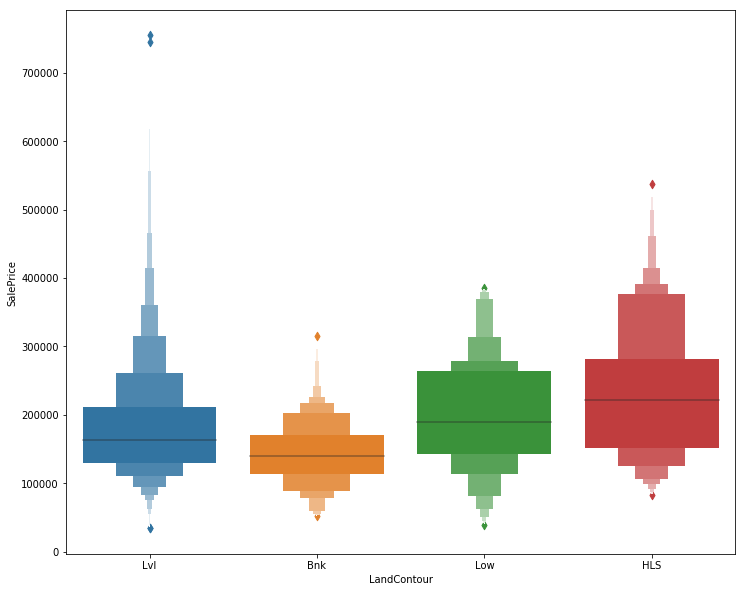

In [74]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='LandContour', y='SalePrice', data=train)
plt.show()

**Hillside has the highest median price, possibly because it is harder to build.**

In [75]:
X_train['LandContour'] = train['LandContour'].copy()
X_test['LandContour'] = test['LandContour'].copy()

### Utilities

In [76]:
all_attrib[8]

'Utilities'

In [77]:
data_describ(data_dict, 'Utilities')

Utilities :  Type of utilities available
	 AllPub :  All public Utilities (E,G,W,& S)
	 NoSewr :  Electricity, Gas, and Water (Septic Tank)
	 NoSeWa :  Electricity and Gas Only
	 ELO :  Electricity only


In [78]:
train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

**This attribute is definitely not useful due to the limited amount of data we have. Almost all houses now have all types of utilities available.**

***We will NOT include this attribute!***

### LotConfig

In [79]:
all_attrib[9]

'LotConfig'

In [80]:
data_describ(data_dict, 'LotConfig')

LotConfig :  Lot configuration
	 Inside :  Inside lot
	 Corner :  Corner lot
	 CulDSac :  Cul-de-sac
	 FR2 :  Frontage on 2 sides of property
	 FR3 :  Frontage on 3 sides of property


*Cul-de-sac is a street with only one inlet or outlet (i.e. dead end).*

In [81]:
train['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

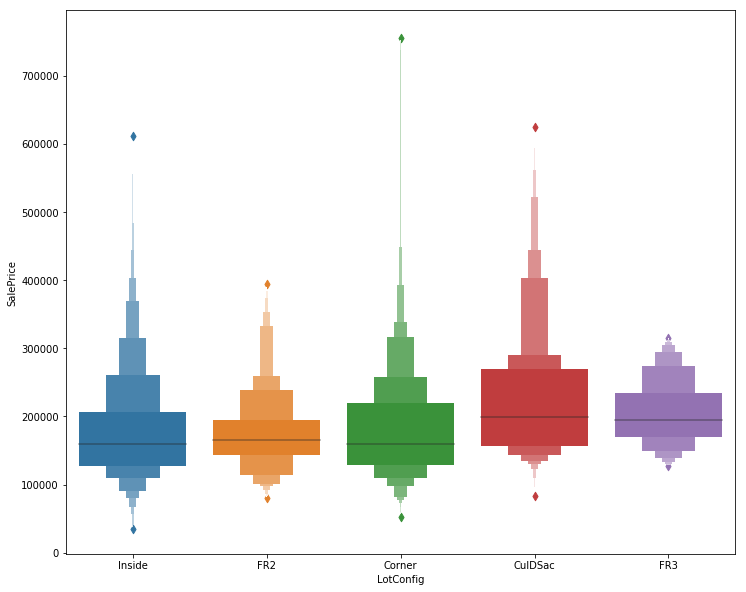

In [82]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='LotConfig', y='SalePrice', data=train)
plt.show()

**Looks like LotConfig itself does not have much effect on SalePrice. We will include this attribute to see if it will help predict the price.**

In [83]:
X_train['LotConfig'] = train['LotConfig'].copy()
X_test['LotConfig'] = test['LotConfig'].copy()

### LandSlope

In [84]:
all_attrib[10]

'LandSlope'

In [85]:
data_describ(data_dict, 'LandSlope')

LandSlope :  Slope of property
	 Gtl :  Gentle slope
	 Mod :  Moderate Slope
	 Sev :  Severe Slope


In [86]:
train['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Again, since it is the level of slopeness, it is probably better to convert into integer type.

In [87]:
landslope_int = cat_to_int(train, 'LandSlope', ['Gtl', 'Mod', 'Sev'])

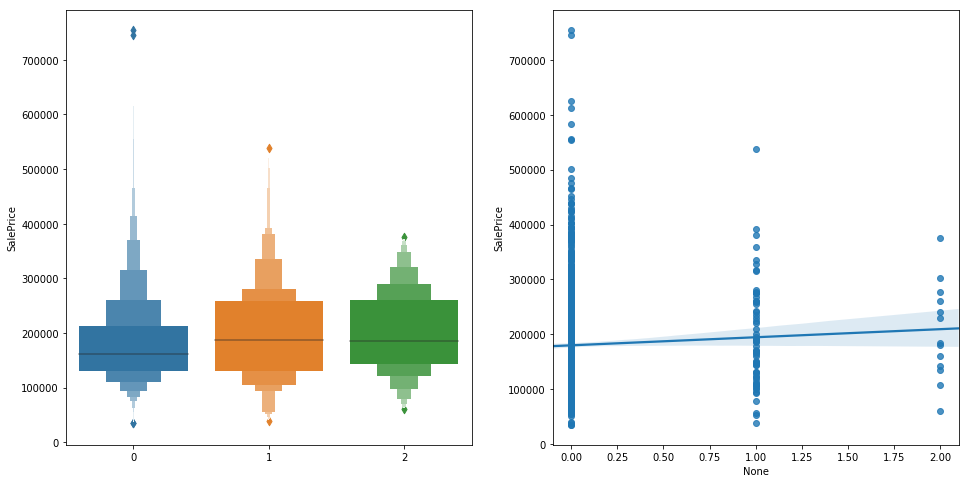

In [88]:
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1, 2, 1)
sns.boxenplot(x=landslope_int, y=train['SalePrice'])

plt.subplot(1, 2, 2)
sns.regplot(x=landslope_int, y=train['SalePrice'], order=1)

plt.show()

**LandSlope does not seem to affect much on SalePrice, and it does not show direct correlation with SalePrice.**

In [89]:
X_train['LandSlope_int'] = landslope_int
X_test['LotConfig'] = cat_to_int(test, 'LandSlope', ['Gtl', 'Mod', 'Sev'])

### Neighborhood

In [90]:
all_attrib[11]

'Neighborhood'

In [91]:
data_describ(data_dict, 'Neighborhood')

Neighborhood :  Physical locations within Ames city limits
	 Blmngtn :  Bloomington Heights
	 Blueste :  Bluestem
	 BrDale :  Briardale
	 BrkSide :  Brookside
	 ClearCr :  Clear Creek
	 CollgCr :  College Creek
	 Crawfor :  Crawford
	 Edwards :  Edwards
	 Gilbert :  Gilbert
	 IDOTRR :  Iowa DOT and Rail Road
	 MeadowV :  Meadow Village
	 Mitchel :  Mitchell
	 Names :  North Ames
	 NoRidge :  Northridge
	 NPkVill :  Northpark Villa
	 NridgHt :  Northridge Heights
	 NWAmes :  Northwest Ames
	 OldTown :  Old Town
	 SWISU :  South & West of Iowa State University
	 Sawyer :  Sawyer
	 SawyerW :  Sawyer West
	 Somerst :  Somerset
	 StoneBr :  Stone Brook
	 Timber :  Timberland
	 Veenker :  Veenker


In [92]:
train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

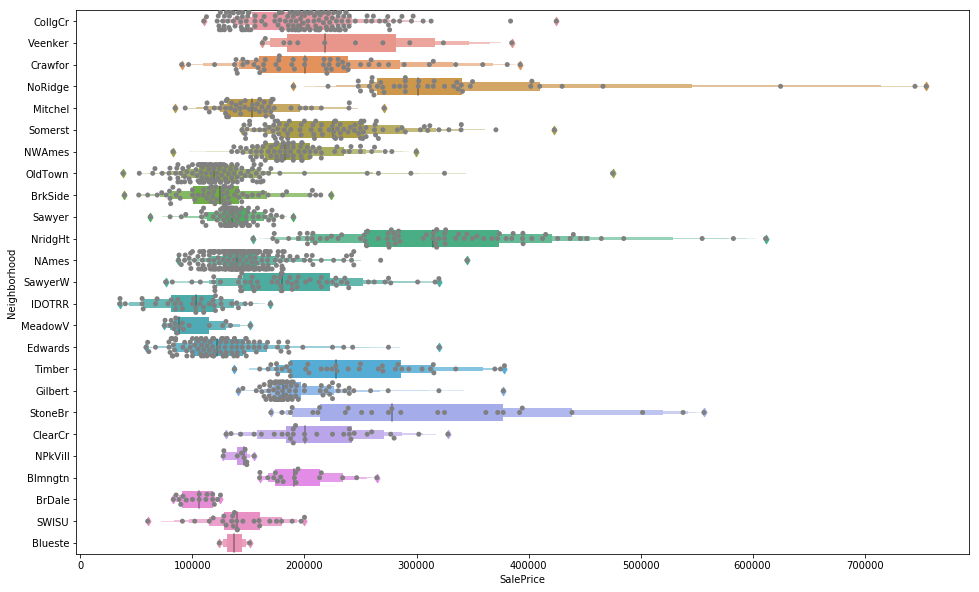

In [93]:
plt.subplots(figsize=(16,10))
sns.boxenplot(y='Neighborhood', x='SalePrice', data=train, orient='h')
sns.swarmplot(y='Neighborhood', x='SalePrice', data=train, color='.5')
plt.show()

**Neighborhood is definitely an important feature, since the location usually decides the price range of a house. Let's include this attribute to see how much it is influencing price.**

In [94]:
X_train['Neighborhood'] = train['Neighborhood'].copy()
X_test['Neighborhood'] = test['Neighborhood'].copy()

### Condition1

In [95]:
all_attrib[12:14]

['Condition1', 'Condition2']

In [96]:
data_describ(data_dict, 'Condition1')

Condition1 :  Proximity to various conditions
	 Artery :  Adjacent to arterial street
	 Feedr :  Adjacent to feeder street
	 Norm :  Normal
	 RRNn :  Within 200' of North-South Railroad
	 RRAn :  Adjacent to North-South Railroad
	 PosN :  Near positive off-site feature--park, greenbelt, etc.
	 PosA :  Adjacent to postive off-site feature
	 RRNe :  Within 200' of East-West Railroad
	 RRAe :  Adjacent to East-West Railroad


In [97]:
data_describ(data_dict, 'Condition2')

Condition2 :  Proximity to various conditions (if more than one is present)
	 Artery :  Adjacent to arterial street
	 Feedr :  Adjacent to feeder street
	 Norm :  Normal
	 RRNn :  Within 200' of North-South Railroad
	 RRAn :  Adjacent to North-South Railroad
	 PosN :  Near positive off-site feature--park, greenbelt, etc.
	 PosA :  Adjacent to postive off-site feature
	 RRNe :  Within 200' of East-West Railroad
	 RRAe :  Adjacent to East-West Railroad


In [98]:
conditions = train['Condition1'] + ' & ' + train['Condition2']
conditions.value_counts()

Norm & Norm        1260
Feedr & Norm         76
Artery & Norm        45
RRAn & Norm          22
PosN & Norm          17
RRAe & Norm          11
PosA & Norm           8
RRAn & Feedr          4
RRNn & Norm           4
Feedr & RRNn          2
PosN & PosN           2
RRNe & Norm           2
Artery & Artery       2
Feedr & RRAe          1
Feedr & Feedr         1
Artery & PosA         1
Feedr & RRAn          1
RRNn & Feedr          1
dtype: int64

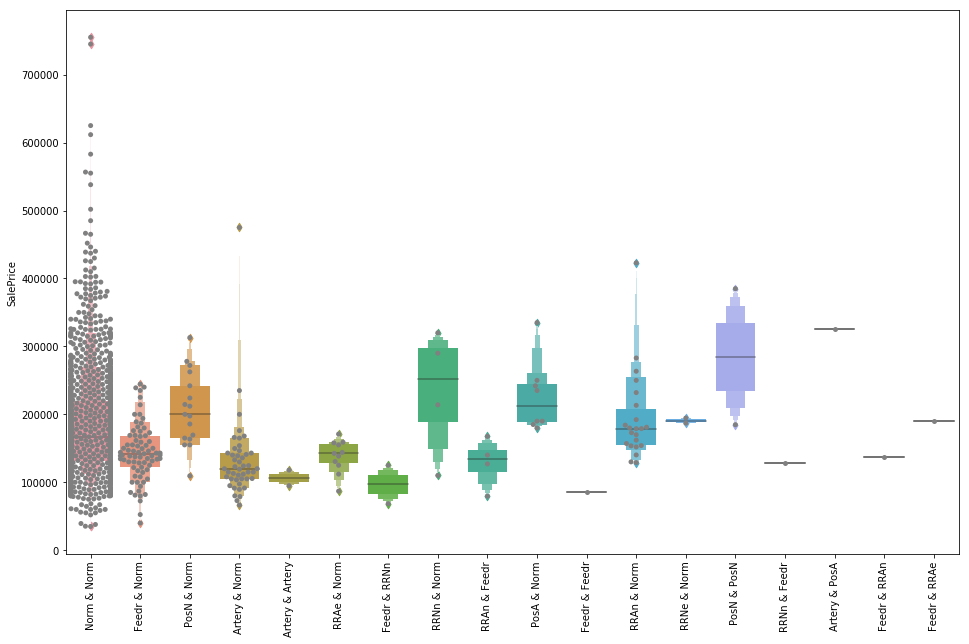

In [99]:
plt.subplots(figsize=(16,10))
sns.boxenplot(x=conditions, y=train['SalePrice'])
sns.swarmplot(x=conditions, y=train['SalePrice'], color='.5')
plt.xticks(rotation=90)
plt.show()

Condition1 and Condition2 are actually 1 parameters. Note that most observations are normal, so we will ignore the specific condition and just focus on whether there is condition or not. Let's create new attribute num_conditions, which counts the number of abnormal conditions.

In [100]:
num_conditions = pd.Series([2-obs.count('Norm') for obs in conditions])
num_conditions[:10]

0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    2
dtype: int64

In [101]:
conditions[:10]

0        Norm & Norm
1       Feedr & Norm
2        Norm & Norm
3        Norm & Norm
4        Norm & Norm
5        Norm & Norm
6        Norm & Norm
7        PosN & Norm
8      Artery & Norm
9    Artery & Artery
dtype: object

In [102]:
num_conditions.value_counts()

0    1260
1     185
2      15
dtype: int64

Awesome! Let's see how it is affecting SalePrice.

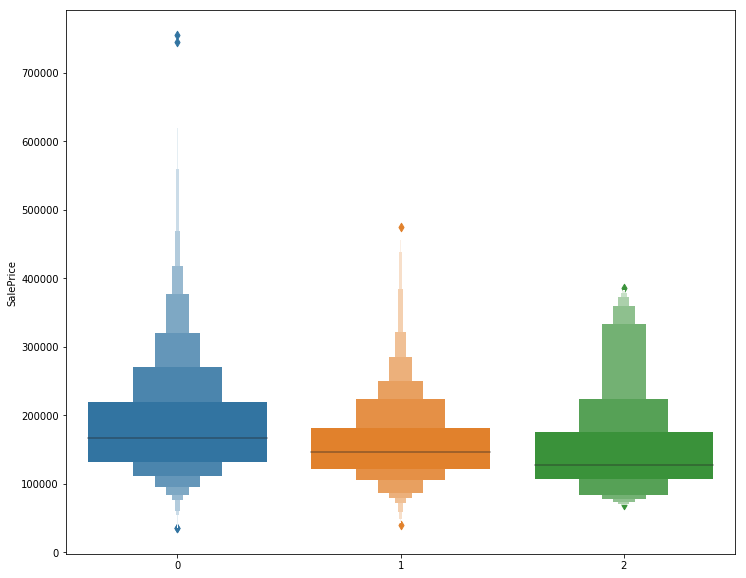

In [103]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x=num_conditions, y=train['SalePrice'])
plt.show()

**Normal houses tend to have a higher median and highest price. We will include num_conditions instead of Condition1 and Condition2.**

In [104]:
X_train['num_conditions'] = num_conditions
X_test['num_conditions'] = pd.Series(
    [int(i != 'Norm') + int(j != 'Norm') for i, j in zip(test['Condition1'], test['Condition2'])]
)

### BldgType

In [105]:
all_attrib[14]

'BldgType'

In [106]:
data_describ(data_dict, 'BldgType')

BldgType :  Type of dwelling
	 1Fam :  Single-family Detached
	 2FmCon :  Two-family Conversion; originally built as one-family dwelling
	 Duplx :  Duplex
	 TwnhsE :  Townhouse End Unit
	 TwnhsI :  Townhouse Inside Unit


In [107]:
train['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

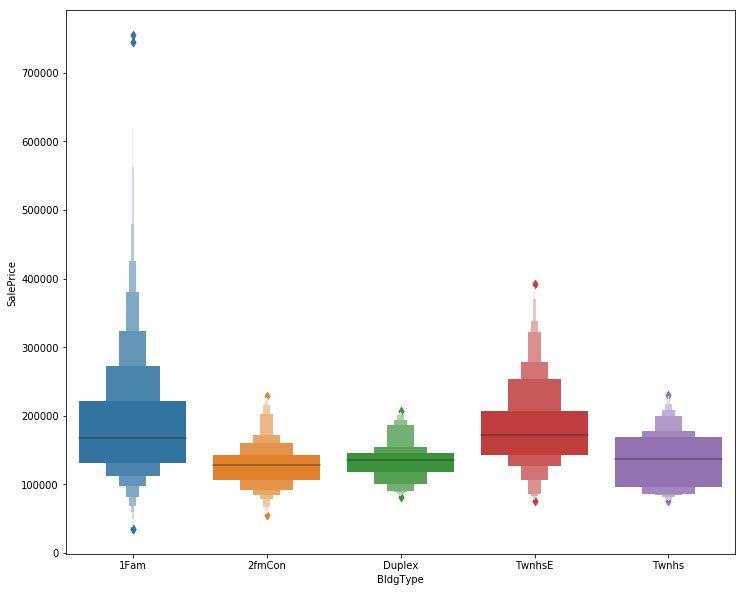

In [108]:
plt.subplots(figsize=(12,10))
sns.boxenplot(x='BldgType', y='SalePrice', data=train)
plt.show()

**1Fam and TwnhsE have approximately the same median at around 160,000, while the median for other three are at around 130,000. We can change those into 2 categories, namely '1Fam or TwnhsE' and 'others', but let's just keep it like this for now.**

### HouseStyle

In [109]:
all_attrib[15]

'HouseStyle'

In [110]:
data_describ(data_dict, 'HouseStyle')

HouseStyle :  Style of dwelling
	 1Story :  One story
	 1.5Fin :  One and one-half story: 2nd level finished
	 1.5Unf :  One and one-half story: 2nd level unfinished
	 2Story :  Two story
	 2.5Fin :  Two and one-half story: 2nd level finished
	 2.5Unf :  Two and one-half story: 2nd level unfinished
	 SFoyer :  Split Foyer
	 SLvl :  Split Level


In [111]:
train['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

This is similar to MSSubClass, let's see if those two matches. (For example, 1Story here should correspond to 1-story in MSSubClass.)

In [112]:
story = {0.0: '', 1.0: '1Story', 1.5: '1.5', 2: '2Story', 2.5: '2.5'}
unmatch = []
for i in range(train.shape[0]):
    if story.get(mssubclass_story['MSSubClass_story'][i]) not in train['HouseStyle'][i]:
        unmatch.append((X_train['MSSubClass'][i], train['HouseStyle'][i]))

for j in unmatch:
    print(j)

('1-1/2 STORY FINISHED ALL AGES', '2Story')
('1-1/2 STORY FINISHED ALL AGES', '2Story')
('2-1/2 STORY ALL AGES', '2Story')
('1-STORY PUD (Planned Unit Development) - 1946 & NEWER', 'SFoyer')
('1-STORY 1946 & NEWER ALL STYLES', '2Story')
('1-STORY 1945 & OLDER', '1.5Fin')
('1-STORY 1946 & NEWER ALL STYLES', 'SLvl')
('2-STORY 1946 & NEWER', 'SLvl')
('2-STORY 1945 & OLDER', '2.5Fin')
('1-STORY 1945 & OLDER', '1.5Unf')
('1-1/2 STORY FINISHED ALL AGES', '2Story')


Out of 1460 ovservations, 11 are mismatched. It is impossible to tell which attribute is correct. Note that MSSubClass is an attribute that combines HouseStyle and some other attributes such as year built, thus we need to revalue MSSubClass when we finish analyzing other attributes. Let's add this to TO DO list.

***TO DO: after analyzing all the attributes, make adjustment to MSSubClass.***

**Since HouseStyle is an attribute that specifically deals with the type of dwell and whether finished or not, we will include this instead of mssubclass_story.**

In [113]:
X_train['HouseStyle'] = train['HouseStyle'].copy()
X_test['HouseStyle'] = test['HouseStyle'].copy()

### OverallQual

In [114]:
all_attrib[16]

'OverallQual'

In [115]:
data_describ(data_dict, 'OverallQual')

OverallQual :  Rates the overall material and finish of the house
	 10 :  Very Excellent
	 9 :  Excellent
	 8 :  Very Good
	 7 :  Good
	 6 :  Above Average
	 5 :  Average
	 4 :  Below Average
	 3 :  Fair
	 2 :  Poor
	 1 :  Very Poor


Obviously, higher quality houses should have a higher price, let's see if this is correct.

In [116]:
train['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

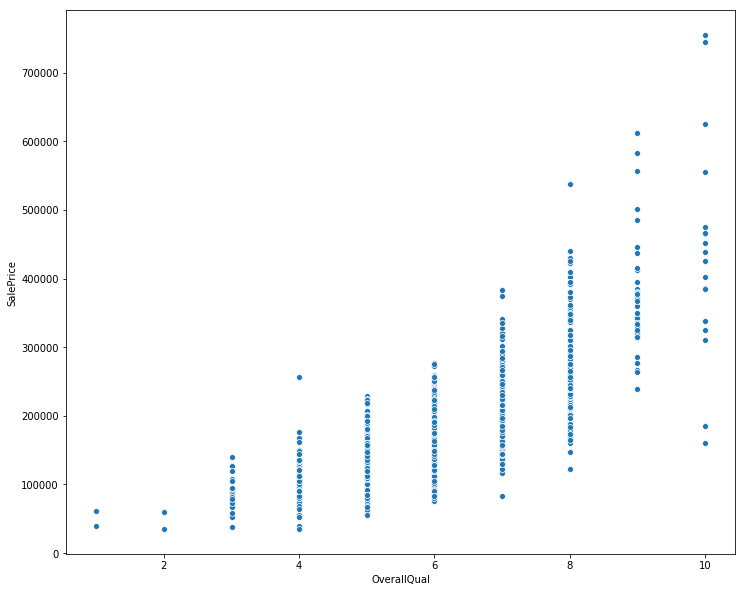

In [117]:
plt.subplots(figsize=(12,10))
sns.scatterplot(x='OverallQual', y='SalePrice', data=train)
plt.show()

**It is very clear that our hypothesis is correct. Higher quality indeed leads to high price.**

In [118]:
X_train['OverallQual'] = train['OverallQual'].copy()
X_test['OverallQual'] = test['OverallQual'].copy()

### OverallCond

In [119]:
all_attrib[17]

'OverallCond'

In [120]:
data_describ(data_dict, 'OverallCond')

OverallCond :  Rates the overall condition of the house
	 10 :  Very Excellent
	 9 :  Excellent
	 8 :  Very Good
	 7 :  Good
	 6 :  Above Average
	 5 :  Average
	 4 :  Below Average
	 3 :  Fair
	 2 :  Poor
	 1 :  Very Poor


Again, a house with excellent condition should have a higher price. Let's check.

In [121]:
train['OverallCond'].value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

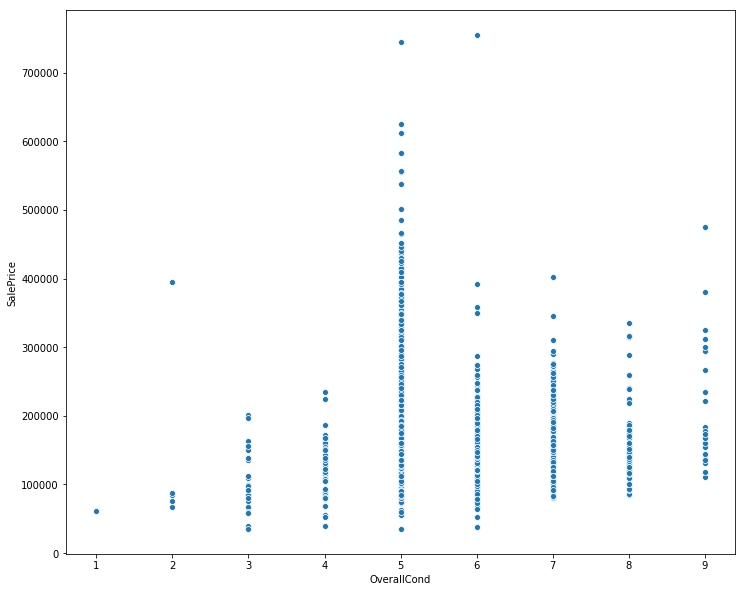

In [122]:
plt.subplots(figsize=(12,10))
sns.scatterplot(x='OverallCond', y='SalePrice', data=train)
plt.show()

Interestingly, the correlation is not as obvious and strong as OverallQual. Looks like higher condition does not necessarily lead to higher price. Let's check the relationship between OverallQual and OverallCond.(i.e. is high quality the same as good condition)

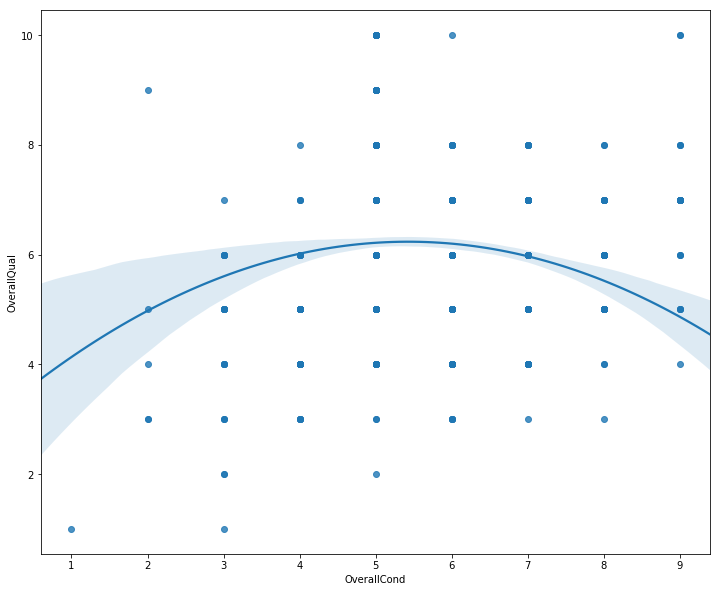

In [123]:
plt.subplots(figsize=(12,10))
sns.regplot(x='OverallCond', y='OverallQual', data=train, order=2)
plt.show()